In [15]:
from aicsimageio import AICSImage
import numpy as np
import itk
import SimpleITK as sitk
from skimage.exposure import equalize_adapthist
import matplotlib.pyplot as plt
from monai.transforms import Flip

## resources

1. Key: SimpleITK-SimpleElastix pypi build: https://pypi.org/project/SimpleITK-SimpleElastix/ . This makes installation painless.
2. SimpleElastix tutorial: https://simpleelastix.readthedocs.io/RigidRegistration.html 

Note: There are registration modules in ITK, registration modules in SimpleITK (https://simpleitk.readthedocs.io/en/master/link_ImageRegistrationMethod3_docs.html), registration modules in Elastix (https://elastix.lumc.nl/download/elastix-5.0.1-manual.pdf), registration modules in SimpleElastix (https://simpleelastix.github.io/). You can find ITK + Elastix (https://github.com/InsightSoftwareConsortium/ITKElastix). But, the easiest thing is the combination of SimpleITK + SimpleElastix, which is our final solution here. 

In [29]:
# load images
img_1 = AICSImage("sample_d000_toy.tiff").get_image_data("ZYX")
img_2 = AICSImage("sample_d180_toy.tiff").get_image_data("ZYX")
print(img_1.shape)
print(img_2.shape)

The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).


(158, 512, 512)
(248, 512, 512)


In [17]:
flip_lr = Flip(spatial_axis=1)
img_2_flip = flip_lr(img_2).astype(np.float32)

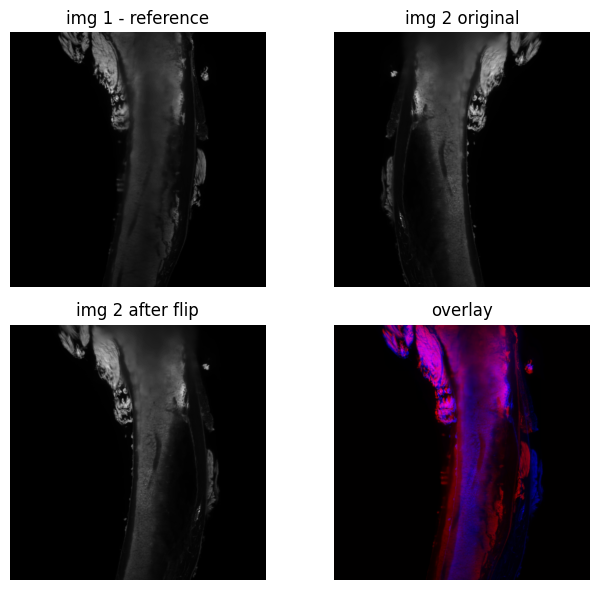

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(7, 6))
ax = axes.ravel()

ax[0].imshow(img_1[127,:,:], cmap=plt.cm.gray)
ax[0].set_title("img 1 - reference")

ax[1].imshow(img_2[159, :, :], cmap=plt.cm.gray)
ax[1].set_title("img 2 original")

ax[2].imshow(img_2_flip[159, :, :], cmap=plt.cm.gray)
ax[2].set_title("img 2 after flip")

img_a = img_1[127,:,:]
img_a = equalize_adapthist(img_a)
img_b = img_2_flip[159, :, :]
img_b = equalize_adapthist(img_b)
img_rgb = np.stack([img_a, np.zeros_like(img_a), img_b], axis=-1)

ax[3].imshow(img_rgb)
ax[3].set_title("overlay")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()
plt.show()

In [19]:
fix_image_sitk = sitk.GetImageFromArray(img_1.astype(np.float32))
mov_image_sitk = sitk.GetImageFromArray(img_2_flip.astype(np.float32))

In [20]:
selx = sitk.ElastixImageFilter()
selx.SetMovingImage(mov_image_sitk)
selx.SetParameterMap(selx.GetDefaultParameterMap('rigid'))
selx.SetFixedImage(fix_image_sitk)
selx.Execute()

Installing all components.
InstallingComponents was successful.

ELASTIX version: 5.000
Command line options from ElastixBase:
-fMask    unspecified, so no fixed mask used
-mMask    unspecified, so no moving mask used
-out      ./
-threads  unspecified, so all available threads are used
  The default value "true" is used instead.

  From elastix 4.8 it defaults to true!
This may change the behavior of your registrations considerably.

Command line options from TransformBase:
-t0       unspecified, so no initial transform used

Reading images...
Reading images took 0 ms.

  A default pyramid schedule is used.
  A default pyramid schedule is used.
  The default value "false" is used instead.
  The default value "GeometricalCenter" is used instead.
Transform parameters are initialized as: [0, 0, 0, 0, 0, 0]
Scales are estimated automatically.
Scales for transform parameters are: [23936.5, 23936.5, 43648.5, 1, 1, 1]
Initialization of all components (before registration) took: 7 ms.
Prepara

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7efcd4588f60> >

In [21]:
sitk_out_image = selx.GetResultImage()

In [22]:
img_reg = sitk.GetArrayFromImage(sitk_out_image)

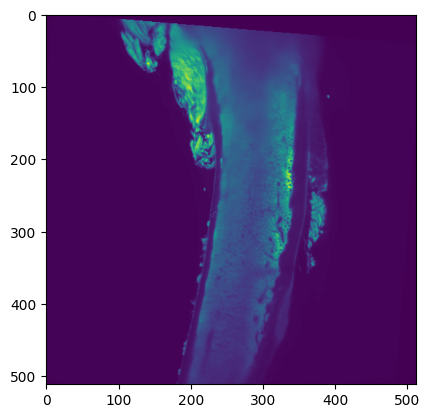

In [27]:
plt.imshow(img_reg[127, :, :])

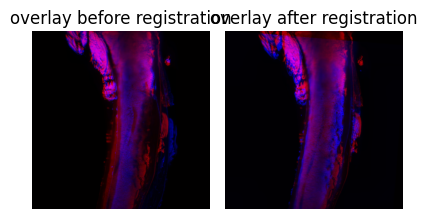

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(4, 6))
ax = axes.ravel()

img_a = img_1[127,:,:]
img_a = equalize_adapthist(img_a)
img_b = img_2_flip[159, :, :]
img_b = equalize_adapthist(img_b)
img_rgb = np.stack([img_a, np.zeros_like(img_a), img_b], axis=-1)

ax[0].imshow(img_rgb)
ax[0].set_title("overlay before registration")

img_c = img_reg[127, :, :]
img_c = equalize_adapthist(img_c)
img_rgb_2 = np.stack([img_a, np.zeros_like(img_a), img_c], axis=-1)

ax[1].imshow(img_rgb_2)
ax[1].set_title("overlay after registration")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()
plt.show()